# Basic Data Loaders

This notebook provides examples of basic data loaders contained in this repository. The basic loader can be used in common deep learning frameworks, but is not optimized. 


In [1]:
import sys

# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from tornet.data.loader import read_file, TornadoDataLoader
except ImportError as e:
    print("WARNING: cannot import tornet library. Many cells below won't work. Install tornet or run sys.path.append('../') and rerun this cell")
    raise e


The following sections demonstrate how to extract data from nc files to be used in python.  

Start by getting a list of all files that you want to include in a dataset:

In [2]:
# Set path to tornet dataset
# Assumes .tar.gz files are extracted.
# this directory should contain catalog.csv, train/ , test/
data_root= 'C:/Users/mjhig/tornet_2013'

# Load catalog of all TORNET samples
catalog = pd.read_csv(os.path.join(data_root,'catalog.csv'),parse_dates=['start_time','end_time'])

# Setset catalog to get training data from certain years with strong tornaodes
years = [2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
min_ef = 2

subset = catalog[
    (catalog.start_time.dt.year.isin(years)) & \
    (catalog['type']=='train') & \
    (catalog['ef_number']>=min_ef)
]
file_list = [os.path.join(data_root,f) for f in subset.filename]
print('Found',len(file_list),'files')


Found 2436 files


## Load single file

The nc files can be easily loaded and inspected with the `xarray` package. 

In [3]:
import xarray as xr
ds = xr.open_dataset(file_list[0])
ds

<xarray.Dataset>
Dimensions:            (azimuth: 120, range: 240, time: 4, sweep: 2, lims: 2)
Coordinates:
  * azimuth            (azimuth) float32 202.2 202.8 203.2 ... 260.8 261.2 261.8
  * range              (range) float32 1.22e+05 1.222e+05 ... 1.817e+05
  * time               (time) datetime64[ns] 2013-09-21T04:14:30 ... 2013-09-...
Dimensions without coordinates: sweep, lims
Data variables:
    elevation          (sweep) float64 ...
    frame_labels       (time) uint8 ...
    nyquist_velocity   (time, sweep) float32 ...
    azimuth_limits     (lims) float32 ...
    range_limits       (lims) float32 ...
    DBZ                (time, azimuth, range, sweep) float32 ...
    VEL                (time, azimuth, range, sweep) float32 ...
    KDP                (time, azimuth, range, sweep) float32 ...
    RHOHV              (time, azimuth, range, sweep) float32 ...
    ZDR                (time, azimuth, range, sweep) float32 ...
    WIDTH              (time, azimuth, range, sweep) float32 ...
    range_folded_mask  (time, azimuth, range, sweep) uint8 ...
Attributes:
    site_name:           KDGX
    site_lat:            32.279944
    site_lon:            -89.984444
    MissingDataFlag:     -999.0
    ef_number:           2.0
    event_id:            473963
    episode_id:          78939
    tornado_start_time:  2013-09-21 04:30:00
    tornado_end_time:    2013-09-21 04:33:00
    category:            TOR
    scit_id:             F9
    storm_event_url:     https://www.ncdc.noaa.gov/stormevents/eventdetails.j...

To support loading data into ML models, the helper function `read_file` is provided that uses `xarray` to load data into a dictionary containing `numpy` arrays.

For 4D arrays, the order of dimensions is `(time, azimuth, range, tilt)`

In [4]:
# reads a single file
variables = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']
n_frames = 1 # only take last frame of each sequence
data = read_file(file_list[0],variables=variables,n_frames=n_frames) 

info = {'radar variable':[],'shape':[],'dtype':[]}
for k in data:
    info['radar variable'].append(k)
    info['shape'].append(data[k].shape)
    info['dtype'].append(data[k].dtype)
pd.DataFrame(info).set_index('radar variable')


,shape,dtype
radar variable,,
DBZ,"(1, 120, 240, 2)",float32
VEL,"(1, 120, 240, 2)",float32
KDP,"(1, 120, 240, 2)",float32
RHOHV,"(1, 120, 240, 2)",float32
ZDR,"(1, 120, 240, 2)",float32
WIDTH,"(1, 120, 240, 2)",float32
range_folded_mask,"(1, 120, 240, 2)",float32
label,"(1,)",uint8
category,"(1,)",int64


If you prefer to work with classes, the class `TornadoDataLoader` is also provided and supports iteration and random access:

In [5]:
# Loader class that supports iteration and random access
data_loader = TornadoDataLoader(file_list,variables=variables,n_frames=n_frames)

# random access
data = data_loader[0] 

# iteration
for data in data_loader: 
    break
    

## Data loaders for deep learning

The loaders described above can be wrapped in data loader classes used in deep learning frameworks.

The resulting loaders are simple to build, but are quite slow.  Methods for optimizing these loaders are discussed.

### Tensorflow

To stream data into `tensorflow` model, the method `create_tf_dataset` creates a `tf.data.Dataset` object.


In [ ]:
# from tornet.data.torch.loader import create_tf_dataset
# tf_ds = create_p_dataset(file_list,variables=variables,n_frames=n_frames) 

ImportError: cannot import name 'create_torch_dataset' from 'tornet.data.loader' (c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\tornet\data\loader.py)

#### Re-Save your tf dataset for better performance!
The above uses the `tf.data.Dataset.from_generator` call, which can be quite slow because of lack of parallelization.   To drastically increase the speed of loading into tensorflow, it is recommended to re-save the dataset in the native tensorflow format.   This only needs to be done once per `file_list`, and will create a second copy of the dataset that can be read much faster using native tensorflow readers.  This newly created version of the dataset can be initialized with `tf.data.Dataset.load` in your model training script.

The `save` call works by streaming over the dataset once and creating another (compressed) copy of the data. **Running save will take some time (minutes to hours, depending on how much data is being saved)** and will take up additional disk space, however this is only a one-time cost and makes data streaming much faster at training time.

In [ ]:
# Save dataset in native tensorflow format for MUCH faster read speeds
# This takes a while but only needs to be called once.
#from tornet.data.tf.loader import shard_function
#tf_ds.save('tornado_dataset.tfdataset',compression='GZIP',shard_func=shard_function)

# Load dataset for later use
#tf_ds = tf.data.Dataset.load('tornado_dataset.tfdataset',compression='GZIP')


Another option for speeding up TF loading is to register the dataset into `tensorflow_datasets`.  Instructions for how to do this can be found in `tornet/data/tfds/tornet/README.md`

In [ ]:
# Iterate over TF dataset
for d in tf_ds:
    break

## pytorch

The class `TornadoDataLoader` can be directly used with `torch`'s dataset and dataloader classes.   If possible, it is recommended to set `num_workers` to ensure multiple nc files are read in parallel.


In [15]:
import torch
from torch.utils.data import Dataset

# Torch dataset
class TornadoDataset(TornadoDataLoader,Dataset):
    pass
torch_ds = TornadoDataset(file_list,variables=variables,n_frames=n_frames)

# Torch data loader
batch_size=8
torch_dl = torch.utils.data.DataLoader( torch_ds, batch_size=batch_size, num_workers=8 )


Faster loading speeds for torch can be obtained by rewriting the data into `array_record` format as described here: https://www.tensorflow.org/datasets/tfless_tfds

See `tornet/data/tfds/tornet/README.md` for how to do this.

# Visualization

To visualize individial chips in the dataset, the function `plot_radar` can be used


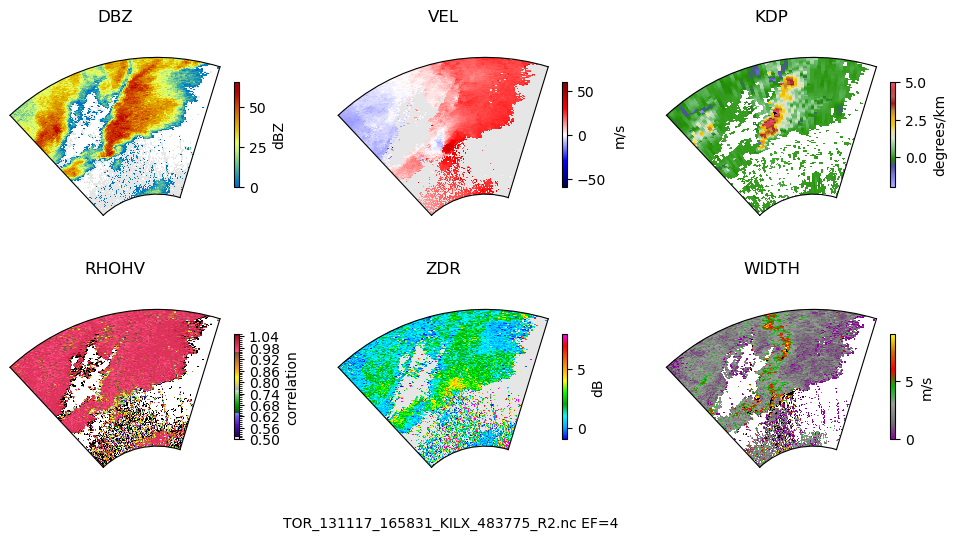

In [20]:
from tornet.data.loader import TornadoDataLoader
from tornet.display.display import plot_radar

# list which variables to plot
vars_to_plot=['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

# Grab a single sample using data loader
dindx =3 # 22
n_frames=4
data_loader = TornadoDataLoader(file_list,variables=vars_to_plot,n_frames=n_frames)
data = data_loader[dindx]

fig = plt.figure(figsize=(12,6))

plot_radar(data,fig=fig,channels=vars_to_plot,include_cbar=True,time_idx=-1,n_rows=2, n_cols=3)

# Add a caption (optional)
fig.text(.5, .05, os.path.basename(data_loader.file_list[dindx])+' EF='+str(data['ef_number'][0]) , ha='center');
